# FFT with Python

If you want to know how the FFT Algorithm works, Jake Vanderplas explained it extremely well in his blog: http://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

Here is, how it is applied and how the axis are scaled to real physical values.

In [1]:
import csv
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-poster')

## First: A synthetic Signal, a simple Sine Wave

In [3]:
t = np.linspace(0, 2*np.pi, 1000, endpoint=True)
f = 3.0 # Frequency in Hz
A = 100.0 # Amplitude in Unit
s = A * np.sin(2*np.pi*f*t) # Signal

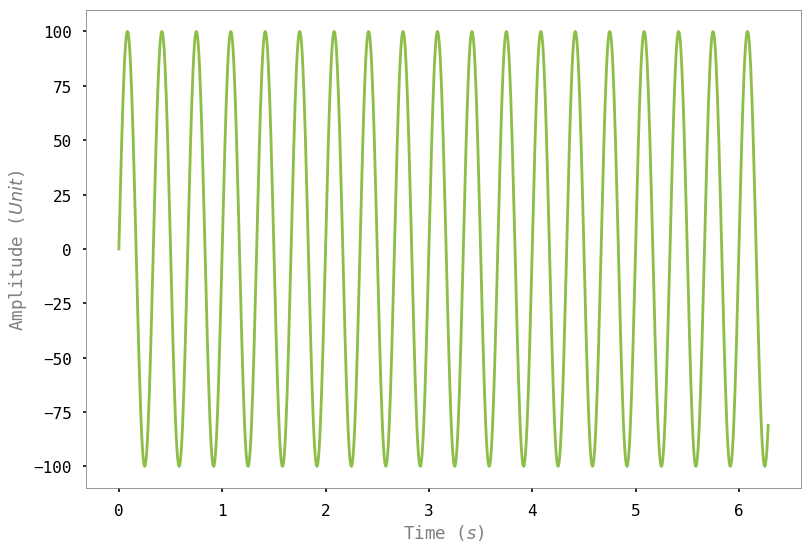

In [21]:
plt.plot(t,s)
plt.xlabel('Time ($s$)')
plt.ylabel('Amplitude ($Unit$)');

## Do the Discrete Fourier Transform with the Blazing Fast FFT Algorithm

In [22]:
Y = np.fft.fft(s)

That's it.

### Let's take a look at the result

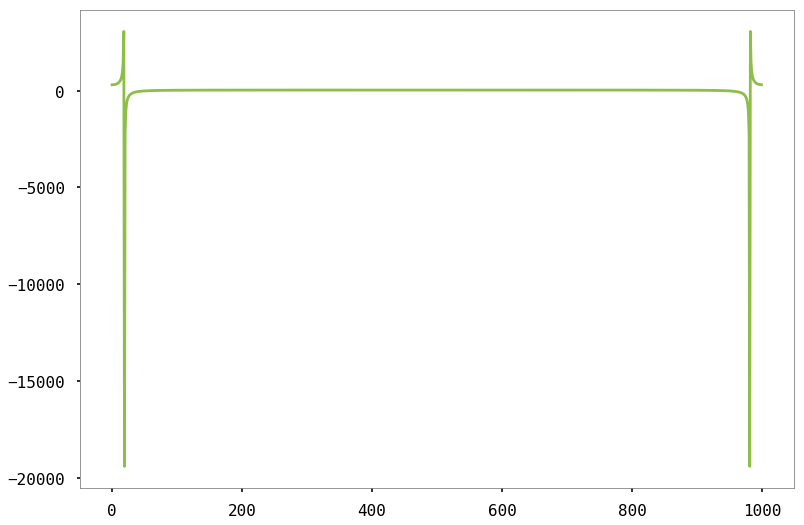

In [23]:
plt.plot(Y);

Hm, looks strange. Something, which is mirrored at the half, right?!

In [25]:
N = int(len(Y)/2+1)
Y[N-4:N+3]

array([35.8278453 -0.34792659j, 35.82789273-0.2319472j ,
       35.82792118-0.11597245j, 35.82793066+0.j        ,
       35.82792118+0.11597245j, 35.82789273+0.2319472j ,
       35.8278453 +0.34792659j])

Can you see it?

And it is something with imaginary parts (the $j$) in it. So let's just take the real part of it with the `abs` command.

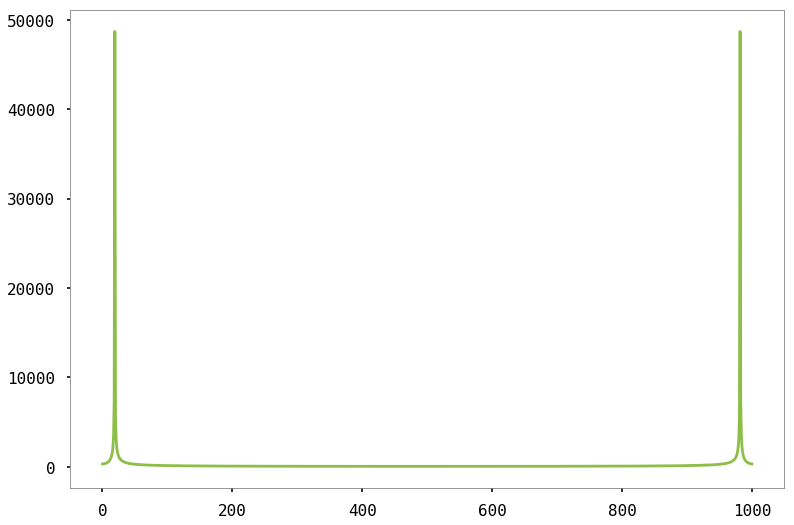

In [27]:
plt.plot(np.abs(Y));

Again, it is perfectly mirrored at the half. So let's just take the first half.

## Amplitude Spectrum

Remember: $N$ is half the length of the output of the FFT.

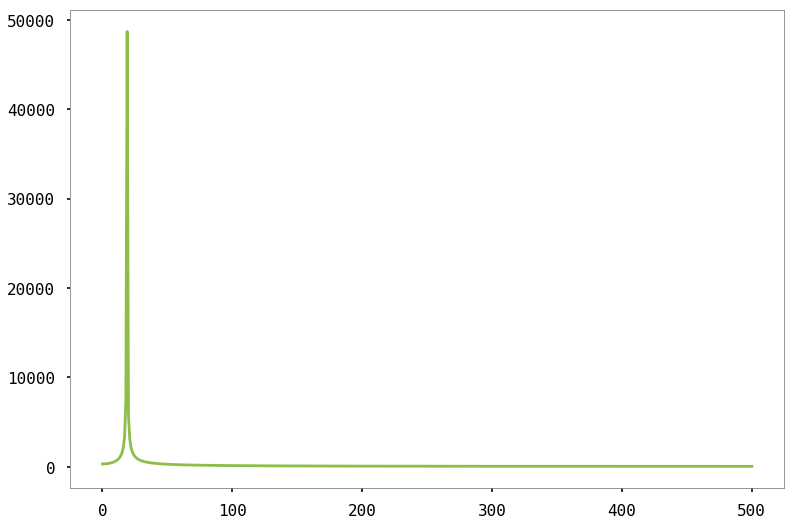

In [29]:
plt.plot(np.abs(Y[:N]));

That looks pretty good. It is called the **amplitude spectrum** of the time domain signal and was calculated with the Discrete Fourier Transform with the *Chuck-Norris-Fast* FFT algorithm. But how to get the x- and y-axis to real physical scaled values?!

## Real Physical Values for the Amplitude and Frequency Axes of the FFT

### x-Axis: The Frequency Axis of the FFT

First, let us determine the timestep, which is used to sample the signal. We made it synthetically, but a real signal has a period (measured every second or every day or something similar). If there is no constant frequency, the FFT can not be used! One can interpolate the signal to a new time base, but then the signal spectrum is not the original one. It depends on the case, if the quality is enough or if the information is getting lost with this shift keying. Enough.

We have a good signal:

In [30]:
dt = t[1] - t[0]
fa = 1.0/dt # scan frequency
print('dt=%.5fs (Sample Time)' % dt)
print('fa=%.2fHz (Frequency)' % fa)

dt=0.00629s (Sample Time)
fa=159.00Hz (Frequency)


Now we need to create a x-Axis vector, which starts from $0.0$ and is filled with $N$ (length of half of the FFT signal) values and going all the way to the maximum frequency, which can be reconstructed. This frequency is half of the maximum sampling frequency ($f_a$) and is called the `Nyquist-Frequency` (see [Nyquist-Shannon Sampling Theorem](http://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)).

In [31]:
X = np.linspace(0, fa/2, N, endpoint=True)
X[:4]

array([0.        , 0.15899579, 0.31799158, 0.47698736])

Now let's plot the amplitude spectrum over the newly created frequency vector $X$

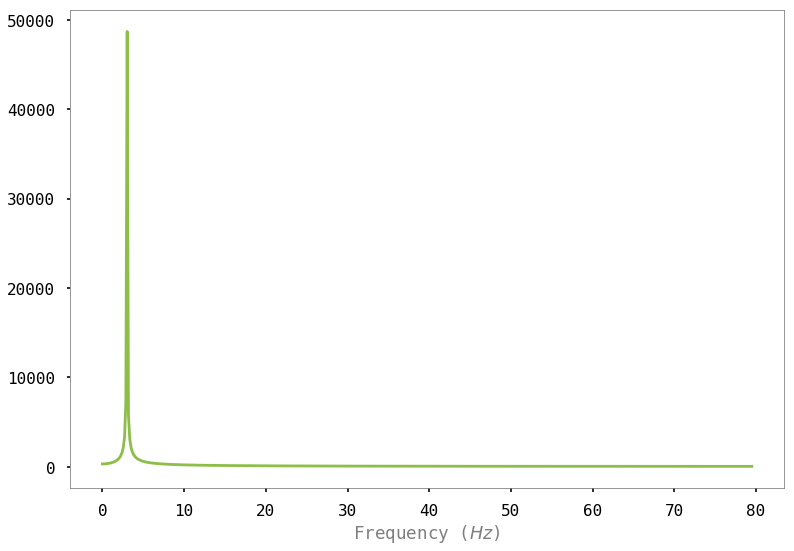

In [33]:
plt.plot(X, np.abs(Y[:N]))
plt.xlabel('Frequency ($Hz$)');

Yeah! The x-Axis is showing us, that we have a peak at exactly these frequencies, from which our synthetically created signal was build of. That was the job.

The sample frequency was $f_a=159Hz$, so the amplitude spectrum is from $0.0$ to $\frac{f_a}{2}=79.5Hz$.

### y-Axis: The Amplitude of the FFT Signal

This task is not this easy, because one have to understand, how the Fourier Transform or the Discrete Fourier Transform works in detail. We need to transform the y-axis value from *something* to a real physical value. Because the power of the signal in time and frequency domain have to be equal, and we just used the left half of the signal (look at $N$), now we need to multiply the amplitude with the factor of **2**. If we inverse the FFT with `IFFT`, the power of the signal is the same.

But that was the easy part. The more complicated one is, if you look at the definition of the Discrete Fourier Transform:

$Y[k]=\frac{1}{N} \underbrace{\sum_{N} x(nT)\cdot e^{-i 2 \pi \frac{k}{N}n}}_{DFT}$

In most implementations, the output $Y$ of the `FFT` is normalized with the number of samples. We have to divide by $N$ to get the real physical value.

The magic factor is $\frac{2}{N}$.

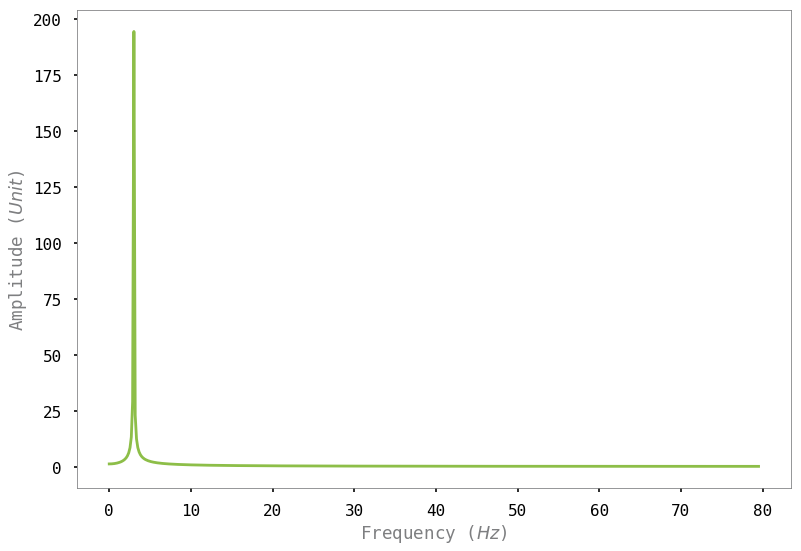

In [35]:
plt.plot(X, 2.0*np.abs(Y[:N])/N)
plt.xlabel('Frequency ($Hz$)')
plt.ylabel('Amplitude ($Unit$)');

Yeah! Job accomplised. Congratulations. But wait...

If you look at the parameters for the original signal ($A$), our signal amplitude was not, what is calculated here. Why??

## The wrong Amplitude Spectrum because of Leakage Effect

Take a look at the original signal.

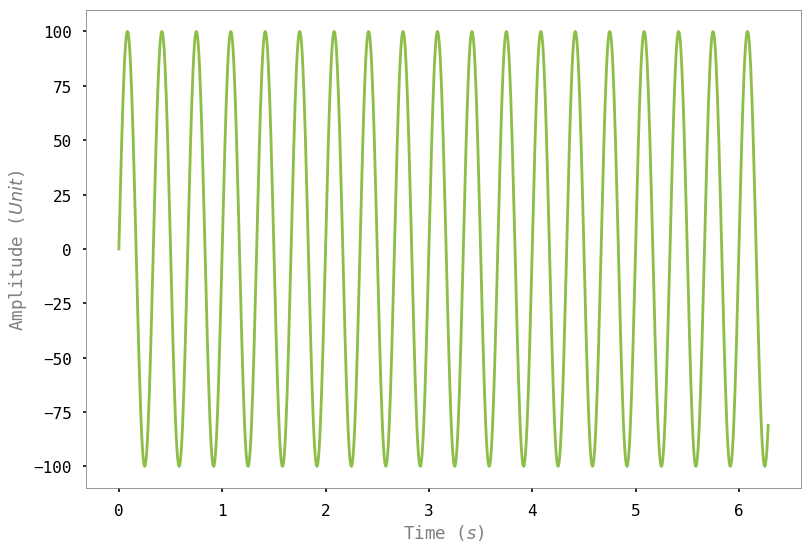

In [37]:
plt.plot(t,s)
plt.xlabel('Time ($s$)')
plt.ylabel('Amplitude ($Unit$)');

Do you see, that the signal do not end at amplitude zero, where it started? That means, if you add these signals up, it looks like this:

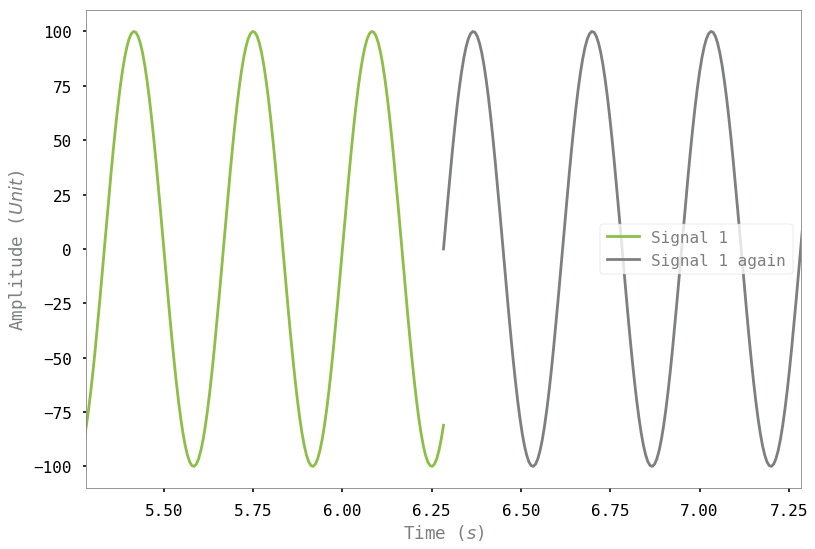

In [39]:
plt.plot(t, s, label='Signal 1')
plt.plot(t+t[-1], s, label='Signal 1 again')
plt.xlim(t[-1]-1, t[-1]+1)
plt.xlabel('Time ($s$)')
plt.ylabel('Amplitude ($Unit$)')
plt.legend();

And the Fourier Transform was originally invented by Mr Fourier for, and only for, periodic signals (see [Fourier Transform](http://en.wikipedia.org/wiki/Fourier_transform)). So the Discrete Fourier Transform does and the Fast Fourier Transform Algorithm does it, too.

The signal has to be strictly periodic, which introduces the so called **windowing** to eliminate the leakage effect.

## Window Functions to get periodic signals from real data

There are a lot of window functions, like the *Hamming*, *Hanning*, *Blackman*, ...

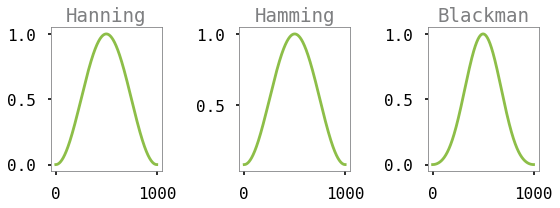

In [40]:
hann = np.hanning(len(s))
hamm = np.hamming(len(s))
black= np.blackman(len(s))

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.plot(hann)
plt.title('Hanning')
plt.subplot(132)
plt.plot(hamm)
plt.title('Hamming')
plt.subplot(133)
plt.plot(black)
plt.title('Blackman')
plt.tight_layout()

All have different characteristics, which is an [own engineering discipline](http://en.wikipedia.org/wiki/Window_function). Let's take the *Hanning* window function to multiply our signal with.

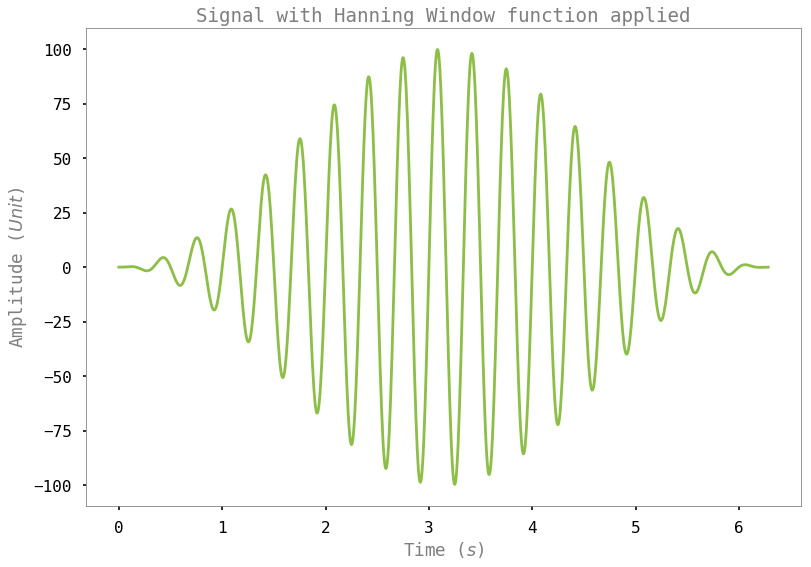

In [42]:
plt.plot(t,hann*s)
plt.xlabel('Time ($s$)')
plt.ylabel('Amplitude ($Unit$)')
plt.title('Signal with Hanning Window function applied');

## FFT with windowed signal

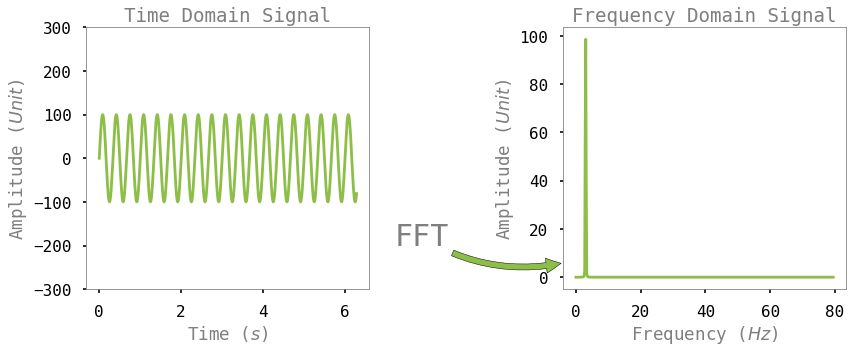

In [51]:
Yhann = np.fft.fft(hann*s)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(t,s)
plt.title('Time Domain Signal')
plt.ylim(np.min(s)*3, np.max(s)*3)
plt.xlabel('Time ($s$)')
plt.ylabel('Amplitude ($Unit$)')

plt.subplot(122)
plt.plot(X, 2.0*np.abs(Yhann[:N])/N)
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency ($Hz$)')
plt.ylabel('Amplitude ($Unit$)')

plt.annotate("FFT",
            xy=(0.0, 0.1), xycoords='axes fraction',
            xytext=(-0.5, 0.2), textcoords='axes fraction',
            size=30, va="center", ha="center",
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=0.2"))
plt.tight_layout()

plt.savefig('FFT.png',bbox_inches='tight', dpi=150, transparent=True)

This is exactly, what we wanted to see: A beautiful amplitude spectrum of our signal, which was calcualted with the FFT algorithm.

Now let's take a look at some real data!

# Vertical Grid Load of Germany

"The vertical grid load is the sum, positive or negative, of all power transferred from the transmission grid through directly connected transformers and power lines to distribution grids and final consumers."

Download the Data from [TransnetBW](https://www.transnetbw.de/de/transparenz/marktdaten/kennzahlen)

In [369]:
netzlast = pd.DataFrame()

for year in range(2022,2023):
    for month in range(1,13):
        url = "https://api.transnetbw.de/verticalNetworkLoad/csv?date={:}-{:02d}".format(year, month)
        print(f"fetching {url}")
        
        netzlast = netzlast.append(pd.read_csv(url, sep=';'))
        
netzlast.index = pd.to_datetime(netzlast['Datum von (ISO 8601)'])
netzlast.index.name = 'Datum'

fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-01
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-02
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-03
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-04
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-05
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-06
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-07
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-08
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-09
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-10
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-11
fetching https://api.transnetbw.de/verticalNetworkLoad/csv?date=2022-12


Interpolate some missing values

In [370]:
netzlast['MW'] = netzlast['Ist-Wert (MW)'].interpolate(method='linear')

In [371]:
netzlast.tail()

,Datum von (ISO 8601),Datum bis (ISO 8601),Prognose (MW),Ist-Wert (MW),MW
Datum,,,,,
2022-12-31 21:45:00+00:00,2022-12-31T21:45:00Z,2022-12-31T22:00:00Z,2756,2778.0,2778.0
2022-12-31 22:00:00+00:00,2022-12-31T22:00:00Z,2022-12-31T22:15:00Z,2752,2878.0,2878.0
2022-12-31 22:15:00+00:00,2022-12-31T22:15:00Z,2022-12-31T22:30:00Z,2736,2850.0,2850.0
2022-12-31 22:30:00+00:00,2022-12-31T22:30:00Z,2022-12-31T22:45:00Z,2722,2833.0,2833.0
2022-12-31 22:45:00+00:00,2022-12-31T22:45:00Z,2022-12-31T23:00:00Z,2683,2729.0,2729.0


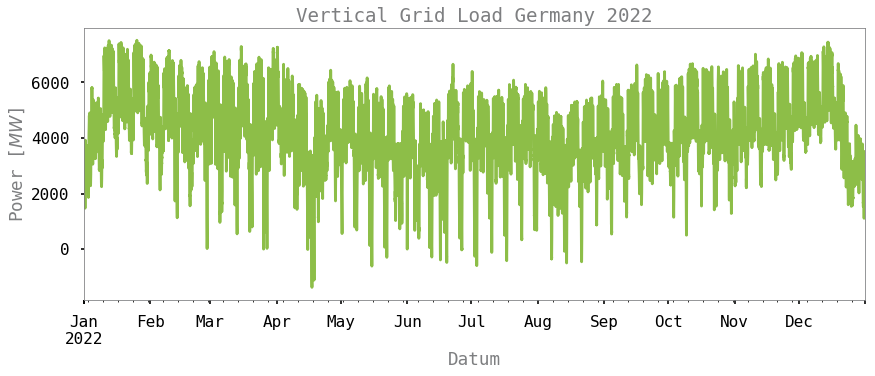

In [372]:
plt.figure(figsize=(14,5))
netzlast['MW'].plot()
plt.title(f'Vertical Grid Load Germany {year}')
plt.ylabel('Power [$MW$]')
plt.savefig(f'VerticalGridLoadGermany{year}.png',bbox_inches='tight', dpi=150, transparent=True)

### Do the FFT

In [373]:
MW = netzlast['MW'].values

In [374]:
hann = np.hanning(len(MW))

In [375]:
Y = np.fft.fft(MW)

In [376]:
N = int(len(Y)/2+1)
fa = 1.0/(15.0*60.0) # every 15 minutes
print('fa=%.4fHz (Frequency)' % fa)

fa=0.0011Hz (Frequency)


In [377]:
X = np.linspace(0, fa/2, N, endpoint=True)

Text(0, 0.5, 'vertical powergrid load ($MW$)')

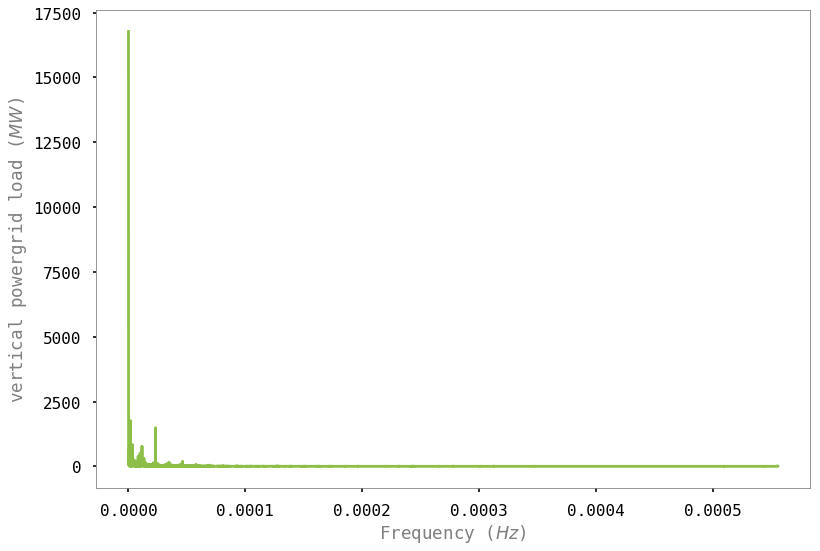

In [378]:
plt.plot(X, 2.0*np.abs(Y[:N])/N)
plt.xlabel('Frequency ($Hz$)')
plt.ylabel('vertical powergrid load ($MW$)')

Hm. This is not what we expected. For humans, the x-axis is not understandable. What is $0.0002Hz$? Let's convert it to period, which is the reciprocal of the sampling rate.

## The Rythm of modern Life, seen in the Power Grid

In [379]:
Xp = 1.0/X # in seconds
Xph= Xp/(60.0*60.0) # in hours

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


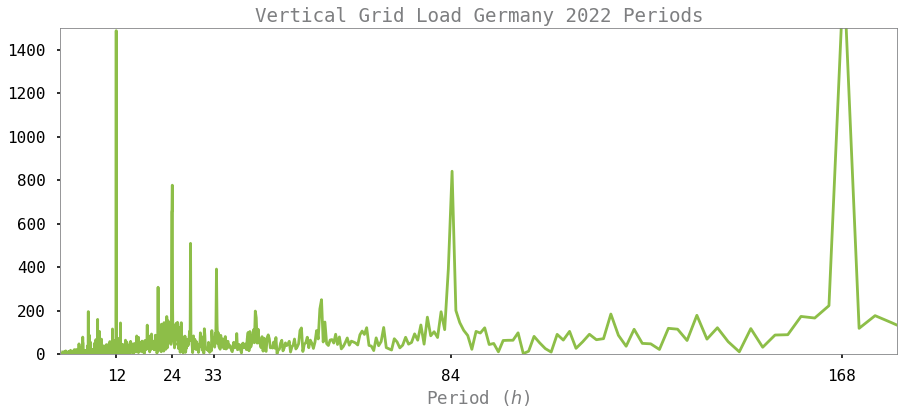

In [380]:
plt.figure(figsize=(15,6))
plt.plot(Xph, 2.0*np.abs(Y[:N])/N)
plt.xticks([12, 24, 33, 84, 168])
plt.xlim(0, 180)
plt.ylim(0, 1500)
plt.xlabel('Period ($h$)')
plt.title(f'Vertical Grid Load Germany {year} Periods')
plt.savefig(f'VerticalGridLoadGermany{year}-FFT.png',bbox_inches='tight', dpi=150, transparent=True)

Aaaaah! Now we see following peaks:

* `12h` day/night rythm
* `24h` daily rythm
* `33.6h` something? Any suggestions?
* `84.2h` something? Any suggestions?
* `168h` week rythm